In [9]:
# Import with pandas 
import pandas as pd
# Parse dates and set date column to index
df = pd.read_csv("my_practice/sales.csv", 
                 parse_dates=["Date"], 
                 #index_col=["Date"]) # parse the date column (tell pandas column 1 is a datetime
                )
df.head()

,Unnamed: 0,Date,Sales
0,0,2021-10-01,29.109547
1,1,2021-10-02,30.720435
2,2,2021-10-03,30.305173
3,3,2021-10-04,27.390893
4,4,2021-10-05,22.841123


DatetimeIndex(['2021-10-01', '2021-10-02', '2021-10-03', '2021-10-04',
               '2021-10-05', '2021-10-06', '2021-10-07', '2021-10-08',
               '2021-10-09', '2021-10-10',
               ...
               '2022-09-21', '2022-09-22', '2022-09-23', '2022-09-24',
               '2022-09-25', '2022-09-26', '2022-09-27', '2022-09-28',
               '2022-09-29', '2022-09-30'],
              dtype='datetime64[ns]', name='Date', length=365, freq=None)

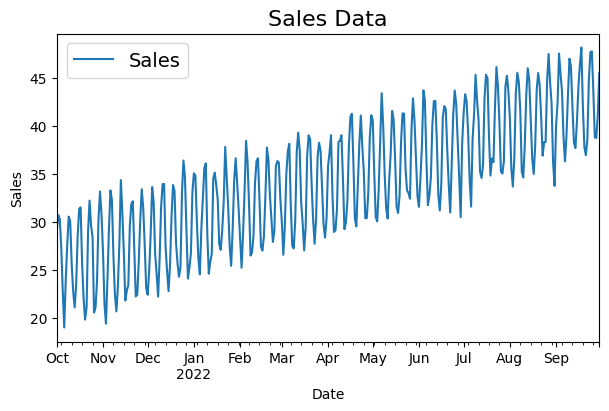

In [21]:
import matplotlib.pyplot as plt
sales = df["Sales"]
sales.plot(figsize=(7, 4))
plt.ylabel("Sales")
plt.title("Sales Data", fontsize=16)
plt.legend(fontsize=14);

In [22]:
len(df)

365

In [64]:
SPLIT_TIME = 300
WINDOW_SIZE = 40
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

In [65]:
time = df["Date"]
series = df["Sales"]

In [66]:
time_train = time[:SPLIT_TIME]
series_train = series[:SPLIT_TIME]
time_valid = time[SPLIT_TIME:]
series_valid = series[SPLIT_TIME:]


In [67]:
import tensorflow as tf

ds = tf.data.Dataset.from_tensor_slices(series_train)
ds = ds.window(WINDOW_SIZE + 1, shift=1, drop_remainder=True)
ds = ds.flat_map(lambda w: w.batch(WINDOW_SIZE + 1))
ds = ds.shuffle(SHUFFLE_BUFFER_SIZE)
ds = ds.map(lambda w: (w[:-1], w[-1]))
ds = ds.batch(BATCH_SIZE).prefetch(1)

In [68]:
 model = tf.keras.models.Sequential([ 
        tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                      strides=1,
                      activation="relu",
                      padding='causal',
                      input_shape=[WINDOW_SIZE, 1]),
      tf.keras.layers.LSTM(64, return_sequences=True),
      tf.keras.layers.LSTM(32),
      tf.keras.layers.Dense(16, activation="relu"),
      tf.keras.layers.Dense(8, activation="relu"),
      tf.keras.layers.Dense(1),
    ]) 

In [70]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 20))
    

optimizer = tf.keras.optimizers.SGD(momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=tf.keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9),
                  metrics=["mae"])

history = model.fit(ds, epochs=50, validation_data=(time_valid,series_valid))

Epoch 1/50


2023-10-10 18:00:16.571441: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-10-10 18:00:16.747273: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-10-10 18:00:16.853242: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-10-10 18:00:17.067551: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-10-10 18:00:17.206632: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


      9/Unknown - 2s 85ms/step - loss: 2.1623 - mae: 2.6217

2023-10-10 18:00:18.043339: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5813954501730510856
2023-10-10 18:00:18.043352: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 16124726177438541304
2023-10-10 18:00:18.043357: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4013984201960197939
2023-10-10 18:00:18.043379: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4669812093677625689
2023-10-10 18:00:18.043387: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15789051943265538091
2023-10-10 18:00:18.043391: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10021921927940519597
2023-10-10 18:00:18.043393: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv 

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported numpy type: NPY_DATETIME).